# LinUCB Hybrid

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Для реализации алгоритма (см Algorithm 2 LinUCB with hybrid linear models в статье -> https://arxiv.org/pdf/1003.0146 ) необходимо прописать два класса по аналогии с работой в семинаре (на семинаре мы реализовывали Algorithm 1 LinUCB with disjoint linear models с той же статьи)


Вот эти классы:
* linucb_hybrid_arm отвечает за обновление информации для конректной ручки (ручка - есть объект этого класса)
* inucb_hybrid_policy отвечает за взаимодействие между ручками (объектами класса linucb_hybrid_arm), включая выбор оптимальной ручки

Можете реализовать с нуля)) Но кажется проще следовать нотациям + обозначения соответсвуют обозначениям в алгоритме статьи

linucb_hybrid_arm  содержит 4 метода:

* init: Создание A, B, b необходимых размеров
* init_arm_features: нужны для идентификации ручки index - чтобы понимать номер рассматриваемой ручки, arm_features - ее фичи
* calc_UCB: подсчитываем оценку реварда с UCB надбавкой для данной ручки на конкретном контексте x_array
* reward_update: обновление информации после получения фидбека (0/1)

In [2]:
"""
обозначения соответсвуют обозначениям в алгоритме статьи

class linucb_hybrid_arm():
    # Note that shared features coefficients beta_hat is calculated outside of each arm since, it is about shared features across individual arms
    
    def __init__(self, d, k, alpha):
        
        # Arm specific A: (d * d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = ...
        
        # B: (d * k) matrix
        # Equals to D_a.T * c_a in ridge regression formulation
        self.B = ...
        
        # b: (d * 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = ...
        
        # Alpha hyperparam
        self.alpha = ...
        
    def init_arm_features(self, arm_index, arm_features_array):
        # Track arm_index
        self.index = arm_index
        
        # arm_features to be used with x_array using outer product to find individual arm z_features
        self.arm_features = arm_features_array
        
        
    def calc_UCB(self, x_array, A_node_inv, beta_hat):
        # beta_hat is the coefficients for Z shared features. (k * 1) vector
        # A_node_inv is (k * k) matrix that is inverse for A_node (shared features)
        
        # Create arm specific z_array with x_array and self.arm_features
        # z_array elements is based on the combination of user and movie features, which is the outer product of both arrays
        # z_array = Outer product = (19 * 29) or (k by d) matrix
        z_array = np.outer(self.arm_features, x_array).reshape(-1,1)
        
        # Find inverse of arm-specific A
        A_inv = ...
        
        # Find theta_arm with beta_hat input
        self.theta = ...
        
        # std deviation -> UCB = mean + alpha* sqrt(s)
        s = ...
        
        
        # UCB
        p = ...
        
        return p
    
    def reward_update(self, reward, x_array, z_array):
        
        # Update A which is (d * d) matrix.
        self.A += ...
        
        # Update B which is (d * k) matrix.
        self.B += ...
        
        # Update b which is (d * 1) vector
        # reward is scalar
        self.b += ...         
"""

'\nобозначения соответсвуют обозначениям в алгоритме статьи\n\nclass linucb_hybrid_arm():\n    # Note that shared features coefficients beta_hat is calculated outside of each arm since, it is about shared features across individual arms\n    \n    def __init__(self, d, k, alpha):\n        \n        # Arm specific A: (d * d) matrix = D_a.T * D_a + I_d. \n        # The inverse of A is used in ridge regression \n        self.A = ...\n        \n        # B: (d * k) matrix\n        # Equals to D_a.T * c_a in ridge regression formulation\n        self.B = ...\n        \n        # b: (d * 1) corresponding response vector. \n        # Equals to D_a.T * c_a in ridge regression formulation\n        self.b = ...\n        \n        # Alpha hyperparam\n        self.alpha = ...\n        \n    def init_arm_features(self, arm_index, arm_features_array):\n        # Track arm_index\n        self.index = arm_index\n        \n        # arm_features to be used with x_array using outer product to find indiv

In [3]:
import numpy as np

class linucb_hybrid_arm():
    def __init__(self, d, k, alpha):
        # Arm-specific parameters
        self.A = np.eye(d)          # (d x d) identity matrix
        self.B = np.zeros((d, k))   # (d x k) zero matrix
        self.b = np.zeros((d, 1))   # (d x 1) zero vector
        self.M = np.zeros((k, k))   # (k x k) for z*z.T
        self.v = np.zeros((k, 1))   # (k x 1) for reward*z
        self.alpha = alpha          # Exploration parameter
        
    def init_arm_features(self, arm_index, arm_features_array):
        self.index = arm_index
        self.arm_features = arm_features_array  # Should be 1D array
        
    def calc_UCB(self, x_array, A_node_inv, beta_hat):
        # Create z vector: outer product of arm features and context
        z_array = np.outer(self.arm_features, x_array).reshape(-1, 1)
        x = x_array.reshape(-1, 1)
        
        A_inv = np.linalg.inv(self.A)
        
        # Compute theta for the arm (Eq 17a)
        self.theta = A_inv @ (self.b - self.B @ beta_hat)
        
        # Mean reward estimate (Eq 14)
        mean = z_array.T @ beta_hat + x.T @ self.theta
        
        # Variance term (Eq 15)
        z_part = z_array.T @ A_node_inv @ z_array
        x_part = x.T @ A_inv @ x
        cross_part = 2 * x.T @ A_inv @ self.B @ A_node_inv @ z_array
        s = z_part + x_part - cross_part
        
        # UCB calculation
        p = mean + self.alpha * np.sqrt(s)
        return p.item()  # Return scalar value
    
    def reward_update(self, reward, x_array, z_array):
        x = x_array.reshape(-1, 1)
        z = z_array.reshape(-1, 1)
        
        # Update matrices (Eq 12-13)
        self.A += x @ x.T
        self.B += x @ z.T
        self.b += reward * x
        
        # Update sufficient statistics for shared part
        self.M += z @ z.T
        self.v += reward * z

class linucb_hybrid_policy():
    def __init__(self, d, k, alpha, n_arms):
        self.d = d
        self.k = k
        self.alpha = alpha
        self.arms = [linucb_hybrid_arm(d, k, alpha) for _ in range(n_arms)]
        
        # Shared parameters
        self.A_node = np.eye(k)     # (k x k) identity
        self.b_node = np.zeros((k, 1))  # (k x 1) zero vector
        self.A_node_inv = np.eye(k)  # Precomputed inverse
        self.beta_hat = np.zeros((k, 1))  # Shared coefficients (Eq 17b)
        
    def select_arm(self, x_array):
        highest_ucb = -float('inf')
        best_arm = 0
        
        # Check if we need to update beta_hat
        if not np.allclose(self.b_node, 0):
            self.beta_hat = self.A_node_inv @ self.b_node
        
        # Find arm with highest UCB
        for arm in self.arms:
            ucb = arm.calc_UCB(x_array, self.A_node_inv, self.beta_hat)
            if ucb > highest_ucb:
                highest_ucb = ucb
                best_arm = arm.index
                
        return best_arm
    
    def update(self, chosen_arm_index, reward, x_array):
        chosen_arm = self.arms[chosen_arm_index]
        
        # Create z vector for the chosen arm
        z_array = np.outer(
            chosen_arm.arm_features, 
            x_array
        ).reshape(-1, 1)
        
        # Update arm-specific parameters
        chosen_arm.reward_update(reward, x_array, z_array)
        
        # Recompute shared parameters from all arms
        self.A_node = np.eye(self.k)
        self.b_node = np.zeros((self.k, 1))
        
        for arm in self.arms:
            A_inv = np.linalg.inv(arm.A)
            
            # Compute terms for shared update (Eq 18-19)
            term_A = arm.M - arm.B.T @ A_inv @ arm.B
            term_b = arm.v - arm.B.T @ A_inv @ arm.b
            
            self.A_node += term_A
            self.b_node += term_b
        
        # Update shared model
        self.A_node_inv = np.linalg.inv(self.A_node)
        self.beta_hat = self.A_node_inv @ self.b_node

linucb_hybrid_policy содержит 5 методов
* init: linucb_arms - лист из объектов класса linucb_hybrid_arm (см семинар)
* НИЧЕГО МЕНЯТЬ НЕ НУЖНО store_arm_features - вызывает метод init_arm_features класса linucb_hybrid_arm, чтобы сохранить новуюб информацию
* select_arm - полностью реализовать самому, возвращает индекс выбранной ручки по аналогии с тем же методом из семинара (но не забывай, следовать другому алгоритму)
* update_shared_features_matrices_phase1: обновить информаию для выбранной руки до того, как будет получен фидбек о вознаграждении для этой руки.
* update_shared_features_matrices_phase2: обновить информаию для выбранной руки после того, как будет получен фидбек о вознаграждении для этой руки..

In [4]:
'''class linucb_hybrid_policy():
    
    def __init__(self, K_arms, d, k, alpha):
        self.K_arms = ...
        self.linucb_arms = ...
        
        # shared A_node: (k * k) matrix
        self.A_node = ...
        
        # shared b_node: (k * 1) corresponding response vector. 
        self.b_node = ...
        
    def store_arm_features(self, arms_features_array):
        # Arms_features_array is multidimension array of shape (K_arms, 1+arm_dimensions), where 1 is for arm_index
    
        # Loop through all arms to store the individual arms
        for i in range(self.K_arms):
        
            self.linucb_arms[i].init_arm_features(arm_index = arms_features_array[i,0], 
                                                  arm_features_array = arms_features_array[i,1:])
        
    def select_arm(self, x_array):
        pass
        
        return 
    
    def update_shared_features_matrices_phase1(self, chosen_arm_B, chosen_arm_A, chosen_arm_b):
        # Use chosen arm's B (d*k), A(d*d), b(k*1) for update of shared feature matrices
        
        chosen_arm_A_inv = ...
        
        self.A_node += ...
        self.b_node += ...
        
    def update_shared_features_matrices_phase2(self, z_array, reward, chosen_arm_B, chosen_arm_A, chosen_arm_b):
        
        chosen_arm_A_inv = ...
        
        self.A_node += ...
        self.b_node += ...'''

import numpy as np

class linucb_hybrid_arm():
    def __init__(self, d, k, alpha):
        # Arm-specific parameters
        self.A = np.eye(d)          # (d x d) identity matrix
        self.B = np.zeros((d, k))   # (d x k) zero matrix
        self.b = np.zeros((d, 1))   # (d x 1) zero vector
        self.M = np.zeros((k, k))   # (k x k) for z*z.T
        self.v = np.zeros((k, 1))   # (k x 1) for reward*z
        self.alpha = alpha          # Exploration parameter
        
    def init_arm_features(self, arm_index, arm_features_array):
        self.index = arm_index
        self.arm_features = arm_features_array  # Should be 1D array
        
    def calc_UCB(self, x_array, A_node_inv, beta_hat):
        # Create z vector: outer product of arm features and context
        z_array = np.outer(self.arm_features, x_array).reshape(-1, 1)
        x = x_array.reshape(-1, 1)
        
        try:
            A_inv = np.linalg.inv(self.A)
        except np.linalg.LinAlgError:
            A_inv = np.linalg.pinv(self.A)
        
        # Compute theta for the arm (Eq 17a)
        self.theta = A_inv @ (self.b - self.B @ beta_hat)
        
        # Mean reward estimate (Eq 14)
        mean = z_array.T @ beta_hat + x.T @ self.theta
        
        # Variance term (Eq 15)
        z_part = z_array.T @ A_node_inv @ z_array
        x_part = x.T @ A_inv @ x
        cross_part = 2 * x.T @ A_inv @ self.B @ A_node_inv @ z_array
        s = z_part + x_part - cross_part
        
        # UCB calculation
        p = mean + self.alpha * np.sqrt(s)
        return p.item()  # Return scalar value
    
    def reward_update(self, reward, x_array, z_array):
        x = x_array.reshape(-1, 1)
        z = z_array.reshape(-1, 1)
        
        # Update matrices (Eq 12-13)
        self.A += x @ x.T
        self.B += x @ z.T
        self.b += reward * x
        
        # Update sufficient statistics for shared part
        self.M += z @ z.T
        self.v += reward * z

class linucb_hybrid_policy():
    def __init__(self, K_arms, d, k, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_hybrid_arm(d, k, alpha) for _ in range(K_arms)]
        
        # Shared parameters
        self.A_node = np.eye(k)     # (k x k) identity
        self.b_node = np.zeros((k, 1))  # (k x 1) zero vector
        self.A_node_inv = np.linalg.inv(self.A_node)  # Precomputed inverse
        self.beta_hat = np.zeros((k, 1))  # Shared coefficients (Eq 17b)
        
    def store_arm_features(self, arms_features_array):
        for i in range(self.K_arms):
            arm_index = int(arms_features_array[i, 0])
            arm_features = arms_features_array[i, 1:]
            self.linucb_arms[i].init_arm_features(arm_index, arm_features)
        
    def select_arm(self, x_array):
        highest_ucb = -float('inf')
        best_arm = 0
        
        # Update shared coefficients
        self.beta_hat = self.A_node_inv @ self.b_node
        
        # Find arm with highest UCB
        for arm in self.linucb_arms:
            ucb = arm.calc_UCB(x_array, self.A_node_inv, self.beta_hat)
            if ucb > highest_ucb:
                highest_ucb = ucb
                best_arm = arm.index
                
        return best_arm
    
    def update_shared_features_matrices_phase1(self, chosen_arm_B, chosen_arm_A, chosen_arm_b):
        # Remove old contribution before arm update
        try:
            A_inv = np.linalg.inv(chosen_arm_A)
        except np.linalg.LinAlgError:
            A_inv = np.linalg.pinv(chosen_arm_A)
        
        # Compute arm's contribution to shared matrices
        term_A = chosen_arm_B.T @ A_inv @ chosen_arm_B
        term_b = chosen_arm_B.T @ A_inv @ chosen_arm_b
        
        # Update shared matrices
        self.A_node -= term_A
        self.b_node -= term_b
        
        # Recompute inverse
        self.A_node_inv = np.linalg.inv(self.A_node)
    
    def update_shared_features_matrices_phase2(self, z_array, reward, chosen_arm_B, chosen_arm_A, chosen_arm_b):
        # Add new contribution after arm update
        try:
            A_inv = np.linalg.inv(chosen_arm_A)
        except np.linalg.LinAlgError:
            A_inv = np.linalg.pinv(chosen_arm_A)
        
        # Compute new contribution from updated arm
        term_A = chosen_arm_B.T @ A_inv @ chosen_arm_B
        term_b = chosen_arm_B.T @ A_inv @ chosen_arm_b
        
        # Update shared matrices
        self.A_node += term_A
        self.b_node += term_b
        
        # Add direct observation
        z = z_array.reshape(-1, 1)
        self.A_node += z @ z.T
        self.b_node += reward * z
        
        # Recompute inverse
        self.A_node_inv = np.linalg.inv(self.A_node)

в ctr_simulator НИЧЕГО МЕНЯТЬ НЕ НУЖНО - отвечает за запуск процесса на выбранных данных

In [5]:
def ctr_simulator(K_arms, d, k, alpha, top_movies_index, top_movies_features, steps_printout):
    # Initiate policy
    linucb_hybrid_policy_object = linucb_hybrid_policy(K_arms = K_arms, d = d, k = k, alpha = alpha)
    
    # Store arm specific features
    linucb_hybrid_policy_object.store_arm_features(top_movies_features.to_numpy())
    
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
  
    data = filtered_data.copy()
            # Initiate unused_data df
    unused_data = pd.DataFrame(columns = ["user_id", "movie_id","rating","reward"])

    for i in range(len(data)):

            user_id = data.loc[i,"user_id"]
            movie_id = data.loc[i, "movie_id"]

            # x_array: User features
            data_x_array = np.array(user_features.query("user_id == @user_id").drop("user_id", axis = 1)) # Shape (1 * 29), d = 29
            data_x_array = data_x_array.reshape(29,1)

            # Obtain rewards
            data_reward = data.loc[i, "reward"]

            if i%steps_printout == 0:
                print("step "+str(i))

            # Find policy's chosen arm based on input covariates at current time step
            chosen_arm_index = linucb_hybrid_policy_object.select_arm(data_x_array)


            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.
            if linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].index  == movie_id:


                # Phase 1: Update shared feature matrices A_node, b_node in policy object
                linucb_hybrid_policy_object.update_shared_features_matrices_phase1(linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].B,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].A,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].b)
                
                # Extract chosen_arm arm_features to create z_array
                data_z_array = np.outer(linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].arm_features, data_x_array).reshape(-1,1)
                
                # Use reward information for the chosen arm to update
                linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].reward_update(data_reward, data_x_array, data_z_array)

                # Phase 2: Update shared feature matrices A_node, b_node in policy object
                linucb_hybrid_policy_object.update_shared_features_matrices_phase2(data_z_array,
                                                                                   data_reward,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].B,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].A,
                                                                                   linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].b)

                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += data_reward
                aligned_ctr.append(cumulative_rewards/aligned_time_steps)
            
            else:
                # Recycle data
                unused_data = pd.concat([unused_data, data.iloc[i]])
        
 

    return {"aligned_time_steps": aligned_time_steps, 
            "cumulative_rewards": cumulative_rewards, 
            "aligned_ctr":aligned_ctr, 
            "policy":linucb_hybrid_policy_object}

# Data Preprocessing

In [6]:
from sklearn.preprocessing import OneHotEncoder

## User data 

In [8]:
user = pd.read_csv("u.user", header = None, sep = "|")
user.columns = ["user_id","age","gender","occupation","zipcode"]
user = user.drop(["zipcode"], axis = 1)

In [9]:
bins = [0, 20, 30, 40, 50, 60, np.inf]
names = ['<20', '20-29', '30-39','40-49', '51-60', '60+']

user['agegroup'] = pd.cut(user['age'], bins, labels=names)
user = user.drop(["age"], axis = 1)
user.head()

,user_id,gender,occupation,agegroup
0,1,M,technician,20-29
1,2,F,other,51-60
2,3,M,writer,20-29
3,4,M,technician,20-29
4,5,F,other,30-39


In [10]:
columnsToEncode = ["agegroup","gender","occupation"]
myEncoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
myEncoder.fit(user[columnsToEncode])

user_features = pd.concat([user.drop(columnsToEncode, axis = 1),
                           pd.DataFrame(myEncoder.transform(user[columnsToEncode]), 
                                        columns = myEncoder.get_feature_names_out(columnsToEncode))], axis=1).reindex()

In [11]:
user_features.head()

,user_id,agegroup_20-29,agegroup_30-39,agegroup_40-49,agegroup_51-60,agegroup_60+,agegroup_<20,gender_F,gender_M,occupation_administrator,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Movie Data (Arm)

In [12]:
movie = pd.read_csv("u.item", header = None, sep = "|", encoding='latin-1')
movie.columns = ["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL", 
                  "unknown", "Action", "Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy",
                  "Film-Noir","Horror", "Musical", "Mystery","Romance","Sci-Fi","Thriller", "War","Western"]

In [13]:
movie_features = movie.drop(["movie_title","release_date", "video_release_date", "IMDb_URL"],axis = 1)
movie_features

,movie_id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Stream data of users with movie ratings & reward

In [14]:
data = pd.read_csv("u.data", sep ="\t", header=None, names = ["user_id", "movie_id","rating", "timestamp"])
data = data.drop(["timestamp"], axis = 1)

На всех данных будет отрабатывать миллион лет)) возьмем первые 10000

Для ответа на ДЗ этого достаточно 

Можете попробовать взять побольше))

In [15]:

data = data.head(10000)

In [16]:
n = 30

# Find total number of ratings instances for top n movies
data.groupby("movie_id").count().sort_values("user_id", ascending = False).head(n)["rating"].sum()

1254

In [17]:
# Obtain top movies index
top_movies_index = data.groupby("movie_id").count().sort_values("user_id", ascending = False).head(n).reset_index()["movie_id"]

In [18]:
top_movies_features = movie_features[movie_features.movie_id.isin(top_movies_index)]

In [19]:
top_movies_features.to_numpy().shape

(30, 20)

In [20]:
filtered_data_original = data[data["movie_id"].isin(top_movies_index)]

filtered_data_original.head()

,user_id,movie_id,rating
12,200,222,5
24,308,1,4
31,301,98,4
50,251,100,4
53,25,181,5


In [21]:
filtered_data_original["reward"] = np.where(filtered_data_original["rating"] <5,0,1)

filtered_data_original = filtered_data_original.reset_index(drop = True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_43340\1568349636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_original["reward"] = np.where(filtered_data_original["rating"] <5,0,1)


In [22]:
filtered_data_original.head()

,user_id,movie_id,rating,reward
0,200,222,5,1
1,308,1,4,0
2,301,98,4,0
3,251,100,4,0
4,25,181,5,1


<Axes: >

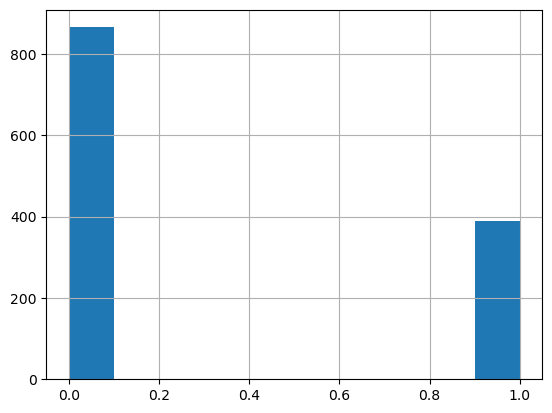

In [23]:
filtered_data_original.reward.hist()

In [24]:
reward_mean = filtered_data_original.reward.mean()
reward_mean

0.310207336523126

In [25]:
# Reshuffling rows to randomise it
np.random.seed(100)
filtered_data = filtered_data_original.reindex(np.random.permutation(filtered_data_original.index)).reset_index(drop = True)

In [26]:
alpha_value = 1.0
simulation_hybrid_alpha_10 = ctr_simulator(K_arms = n, 
                                           d = 29,
                                           k = 29*19,
                                           alpha = alpha_value, 
                                           top_movies_index = top_movies_index, 
                                           top_movies_features=top_movies_features,
                                           steps_printout=200)
plt.plot(simulation_hybrid_alpha_10["aligned_ctr"])
plt.axhline(y=reward_mean, color = "red")
plt.title("alpha = "+str(alpha_value))

step 0


IndexError: list index out of range

step 0
step 200
step 400
step 600
step 800
step 1000
step 1200


Text(0.5, 1.0, 'alpha = 0.25')

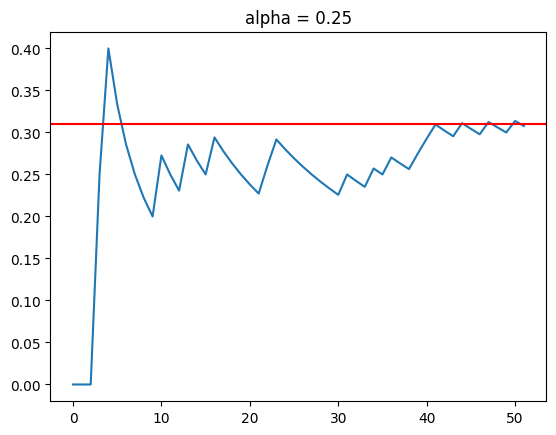

In [ ]:
alpha_value = 0.25
simulation_hybrid_alpha_025 = ctr_simulator(K_arms = n, 
                                           d = 29,
                                           k = 29*19,
                                           alpha = alpha_value, 
                                           top_movies_index = top_movies_index, 
                                           top_movies_features=top_movies_features,
                                           steps_printout=200)
plt.plot(simulation_hybrid_alpha_025["aligned_ctr"])
plt.axhline(y=reward_mean, color = "red")
plt.title("alpha = "+str(alpha_value))

## LinUCB Disjoint Simulation

А здесь нужно реализовать простой алгоритм LinUCB (см Algorithm 1 в статье -> https://arxiv.org/pdf/1003.0146 )

прям копипаст с семинара))



In [27]:
'''# Create class object for a single linear ucb disjoint arm
class linucb_disjoint_arm():
    
    def __init__(self, arm_index, d, alpha):
        
        # Track arm index
        self.arm_index = ...
        
        # Keep track of alpha
        self.alpha = ...
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = ...
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = ...
        
    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression
        A_inv = ...
        
        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta is (d x 1) dimension vector
        self.theta = ...
        
        # Find ucb based on p formulation (mean + std_dev) 
        # p is (1 x 1) dimension vector
        p = ...
        
        return p
    
    def reward_update(self, reward, x_array):
        # Update A which is (d * d) matrix.
        self.A += ...
        # Update b which is (d x 1) vector
        # reward is scalar
        self.b += ...'''

import numpy as np

class linucb_disjoint_arm():
    def __init__(self, arm_index, d, alpha):
        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha (exploration parameter)
        self.alpha = alpha
        
        # A: (d x d) matrix = X_a^T * X_a + I_d (ridge regularization)
        self.A = np.eye(d)  # Identity matrix
        
        # b: (d x 1) response vector = X_a^T * rewards
        self.b = np.zeros((d, 1))
        
    def calc_UCB(self, x_array):
        # Reshape context to column vector
        x = x_array.reshape(-1, 1)
        
        # Find A inverse
        try:
            A_inv = np.linalg.inv(self.A)
        except np.linalg.LinAlgError:
            A_inv = np.linalg.pinv(self.A)  # Use pseudo-inverse if singular
        
        # Ridge regression: theta = A^{-1} * b
        self.theta = A_inv @ self.b
        
        # Calculate point estimate (mean reward)
        mean_reward = self.theta.T @ x
        
        # Calculate standard deviation (uncertainty)
        std_dev = np.sqrt(x.T @ A_inv @ x)
        
        # UCB = mean + alpha * std_dev
        p = mean_reward + self.alpha * std_dev
        
        return p.item()  # Return scalar value
    
    def reward_update(self, reward, x_array):
        # Reshape context to column vector
        x = x_array.reshape(-1, 1)
        
        # Update A: A += x * x^T
        self.A += x @ x.T
        
        # Update b: b += reward * x
        self.b += reward * x

в linucb_disjoint_policy здесь слудует только реализвать функцию выбора ручки 

In [28]:
class linucb_disjoint_policy():
    
    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha) for i in range(K_arms)]
        
    def select_arm(self, x_array):
        pass
        return
    
    def store_arm_index(self, arms_index_array):
    # Arms_features_array is multidimension array of shape (K_arms, 1+arm_dimensions), where 1 is for arm_index

        # Loop through all arms to store the individual arms
        for i in range(self.K_arms):

            self.linucb_arms[i].arm_index = arms_index_array[i]

In [29]:
def ctr_disjoint_simulator(K_arms, d, alpha, top_movies_index, steps_printout):
    # Initiate policy
    linucb_disjoint_policy_object = linucb_disjoint_policy(K_arms = K_arms, d = d, alpha = alpha)
    
    # Store specific arm_index
    linucb_disjoint_policy_object.store_arm_index(top_movies_index.to_numpy())
    
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    data = filtered_data.copy()
            # Initiate unused_data df
    unused_data = pd.DataFrame(columns = ["user_id", "movie_id","rating","reward"])
        
    for i in range(len(data)):

            user_id = data.loc[i,"user_id"]
            movie_id = data.loc[i, "movie_id"]

            # x_array: User features
            data_x_array = np.array(user_features.query("user_id == @user_id").drop("user_id", axis = 1)) # Shape (1 * 29), d = 29
            data_x_array = data_x_array.reshape(29,1)

            # Obtain rewards
            data_reward = data.loc[i, "reward"]

            if i%steps_printout == 0:
                print("step "+str(i))

            # Find policy's chosen arm based on input covariates at current time step
            chosen_arm_index = linucb_disjoint_policy_object.select_arm(data_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.
            if linucb_disjoint_policy_object.linucb_arms[chosen_arm_index].arm_index  == movie_id:

                # Use reward information for the chosen arm to update
                linucb_disjoint_policy_object.linucb_arms[chosen_arm_index].reward_update(data_reward, data_x_array)
                
                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += data_reward
                aligned_ctr.append(cumulative_rewards/aligned_time_steps)
            
            else:
                # Recycle data
                unused_data = pd.concat([unused_data, data.iloc[i]])    
        
                    
    return {"aligned_time_steps": aligned_time_steps, 
            "cumulative_rewards": cumulative_rewards, 
            "aligned_ctr":aligned_ctr, 
            "policy":linucb_disjoint_policy_object}

# Compare Disjoint vs Hybrid (alpha = 0.25) for a single simulation run

In [30]:
alpha_value = 0.25
simulation_disjoint_alpha_025 = ctr_disjoint_simulator(K_arms = n, 
                                                       d = 29,
                                                       alpha = alpha_value, 
                                                       top_movies_index = top_movies_index, 
                                                       steps_printout=200)
plt.plot(simulation_disjoint_alpha_025["aligned_ctr"])
plt.axhline(y=reward_mean, color = "red")
plt.title("alpha = "+str(alpha_value))

step 0


TypeError: list indices must be integers or slices, not NoneType

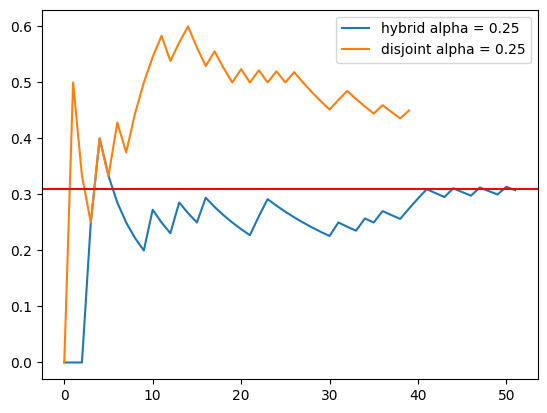

In [ ]:
plt.plot(simulation_hybrid_alpha_025["aligned_ctr"], label = "hybrid alpha = 0.25")
plt.plot(simulation_disjoint_alpha_025["aligned_ctr"], label = "disjoint alpha = 0.25")
plt.axhline(y=reward_mean, color = "red")
plt.legend()

Почему по оси x здесь всего 50 шагов?